In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [23]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Declare a Base using `automap_base()`

Base = automap_base()

# Use the Base class to reflect the database tables

Base.prepare(engine, reflect=True)


In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`

Station = Base.classes.station
Measurement = Base.classes.measurement


In [9]:
# Create a session

session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the data set is:", most_recent_date)

The most recent date in the data set is: 2017-08-23


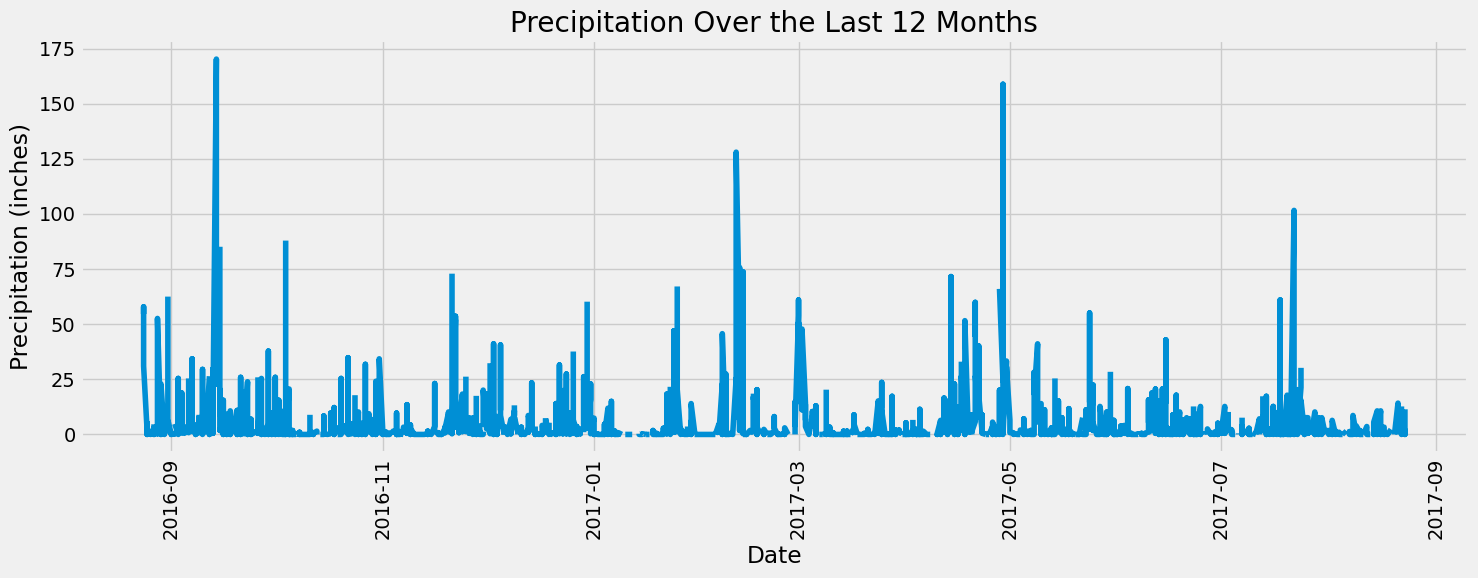

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='date')


# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])



# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['precipitation'])
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_stats = df['precipitation'].describe()

print(summary_stats)


count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset

# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
print("Most active stations:")
for station in active_stations:
    print(station)

Most active stations:
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = active_stations[0][0] 
result = session.query(func.min(Measurement.tobs).label('min_temperature'),
                       func.max(Measurement.tobs).label('max_temperature'),
                       func.avg(Measurement.tobs).label('avg_temperature')).\
            filter(Measurement.station == most_active_station_id).first()
# Extract the values from the result tuple
min_temperature = result.min_temperature
max_temperature = result.max_temperature
avg_temperature = result.avg_temperature

print(min_temperature)
print(max_temperature)
print(avg_temperature)

12.2
29.4
22.03582251082252


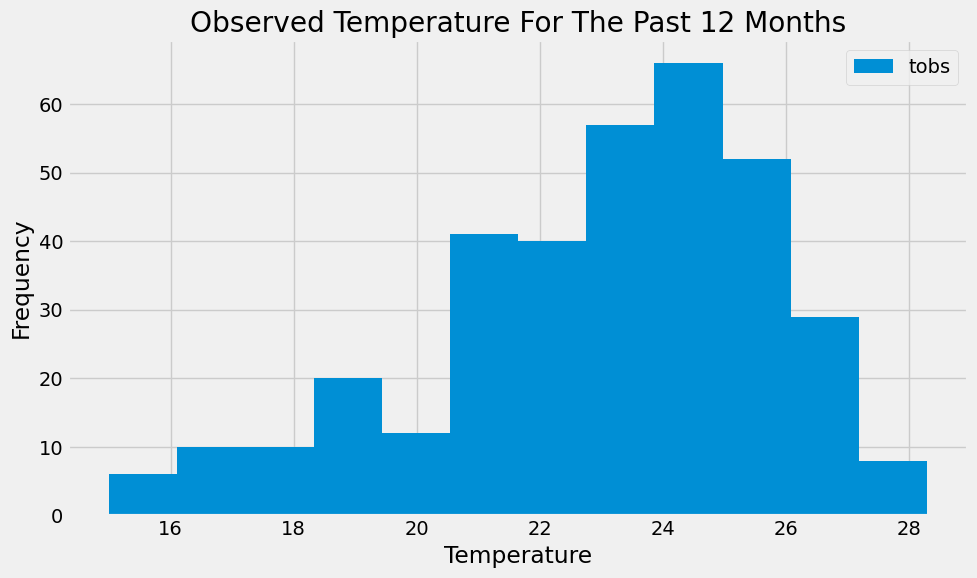

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - dt.timedelta(days=365)

# Query the temperature observations for the most active station for the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

# Extract temperatures from the result
temperatures = [temp[0] for temp in temperature_data]

# Plotting the results as a histogram

plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.title('Observed Temperature For The Past 12 Months')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()
